In [1]:
import ROOT
ROOT.gInterpreter.AddIncludePath("/home/builder/include")
ROOT.gInterpreter.Load("/home/builder/lib/libOPhase.so")

Welcome to JupyROOT 6.12/07


0

In [2]:
%%cpp
#include "Settings.h"
#include "BoundaryConditions.h"
#include "InterfaceEnergy.h"
#include "InterfaceMobility.h"
#include "DoubleObstacle.h"
#include "PhaseField.h"
#include "InterfaceField.h"
#include "DrivingForce.h"
#include "InterfaceEnergy.h"
#include "Initializations.h"
#include "Temperature.h"
#include "UserDrivingForce.h"

In [3]:
%%cpp
openphase::Settings            OPSettings;

OPSettings.Initialize();
OPSettings.ReadInput();

openphase::InterfaceMobilityIdentical   Mu;
openphase::BoundaryConditions  BC(OPSettings);
openphase::PhaseField          Phi(OPSettings);
openphase::DrivingForce        dG;
openphase::InterfaceField      Psi(OPSettings);
openphase::DoubleObstacle      DO(OPSettings);
openphase::UserDrivingForce    DDF;
openphase::Temperature         Tx;

openphase::InterfaceEnergyIdentical Sigma;

Sigma.Initialize(OPSettings);
Mu.Initialize(OPSettings);
dG.Initialize(OPSettings);
DDF.Initialize(OPSettings);
Tx.Initialize(OPSettings);

dG.ReadInput();
BC.ReadInput();
Tx.ReadInput();
Tx.SetInitial(BC);


double t=0, dt=OPSettings.dt ;

openphase::Initializations::Single(Phi, 0, BC, OPSettings);
openphase::Initializations::Sphere(Phi, 1, 10, 32,32,32,  BC, OPSettings);
vector<double> vLatenheat = {0.0, -5.8e8};
DDF.LatentHeat = vLatenheat;

const vector<int> Size = {OPSettings.Nx, OPSettings.Ny, OPSettings.Nz};


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  OpenPhase

  An open-source phase-field simulation library
  www.openphase.de

  Core development: 
  Interdisciplinary Centre for Advanced Materials Simulation (ICAMS) 
  Ruhr University Bochum, Germany 
  2009 - 2016

  Licensed under GNU GPLv3
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Settings                                : Initialized
------------------------------------------------------------
------------------------------------------------------------
Global project parameters source        : ProjectInput/ProjectInput.opi
Simulation Title                        : Multi
--< Model parameters >--------------------------------------
Units of length                         : m
Units of mass                           : kg
Units of time                           : s
Energy units                            : J
Number of OpenMP Threads                : 2
Number of Time Steps                    : 20
Init

In [4]:
%%cpp -d

void run_until(double ts){
    const int MAX_ITER=10000;
    for(int i_=0; i_< MAX_ITER; i_++)
    {
        OP_STORAGE_LOOP_INTERIOR(i,j,k,Phi.Fields)
        {
           Tx(i,j,k) = Tx.T0 - 5*t;
        }
        Sigma.CalculateCubic(Phi);
        Mu.CalculateCubic(Phi);
        DO.GetPsi(Phi, Sigma, Mu, Psi);
        DDF.GetDrivingForce(Phi, Tx, dG);
        dG.Average(Phi, BC);
        dG.MergePsi(Phi, Sigma, Mu, Psi);
        Psi.Normalize(Phi, BC, dt);
        Psi.Merge(Phi, BC, dt);
        t+=dt;
        if(t>=ts)
            break;
    }
}

double get_phi_vol(int phiid=1)
{//# calculate volume fraction of phase `phiid`
    double phisum=0.0;
    for (int j=0; j<Phi.Fields.tot_size(); j++)
        phisum+=Phi.Fields[j].get(phiid);
    return phisum/Phi.Fields.tot_size();
};

In [5]:
def declare_GetFieldFunc(funcname,  cppvar, value_func, ext_para='', id_para1='', id_para2=''):
    Template="""
vector<double> %s(int m %s){
    unsigned int p = 0;
    vector <double> z(Phi.Fields.sizeX()*Phi.Fields.sizeY()*Phi.Fields.sizeZ());
    OP_STORAGE_LOOP_INTERIOR(i,j,k,Phi.Fields)
    {
        z[p] = %s(%s i,j,k %s).%s;
        p++;
    }
    return z;
}
"""
    if hasattr(ROOT,funcname):
        print(funcname , 'already exists. Doing nothing.')
        return
    if ext_para.strip():         ext_para=', ' + ext_para
    if id_para1.strip():         id_para1=id_para1 + ', '
    if id_para2.strip():         id_para2=', ' + id_para2
    ROOT.gInterpreter.Declare(Template%(
        funcname, ext_para, cppvar, id_para1 , id_para2 , value_func
    ))

declare_GetFieldFunc('get_dGavg', 'dG.AveragedAt', 'get_asym(m,n)', 'int n','BC')
declare_GetFieldFunc('get_dG',    'dG.RawAt',      'get_asym(m,n)', 'int n','BC')
declare_GetFieldFunc('get_phi',   'Phi.Fields',    'get(m)'                     )

In [6]:
import matplotlib
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
ROOT.dt=0.001
ROOT.run_until(0.25)
print('Vf(%f)=%f' % (ROOT.t , ROOT.get_phi_vol(1) ))

Vf(0.250000)=0.003012


<IPython.core.display.Javascript object>


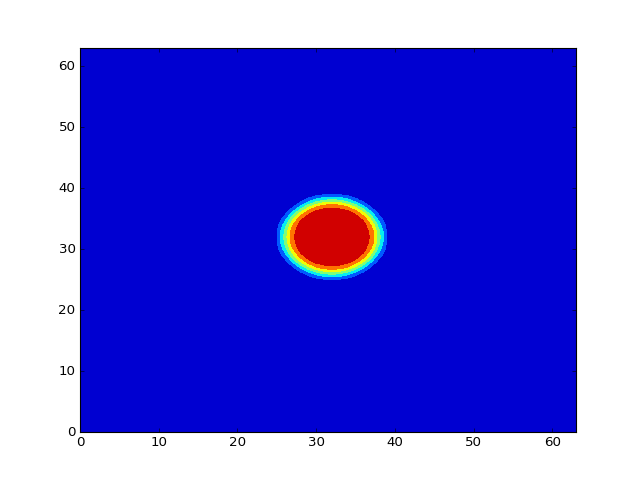

In [16]:
sim_size=np.array(ROOT.Size)
phi=np.array(ROOT.get_phi(1)).reshape(sim_size)
plt.contourf(phi[:,32,:])

<IPython.core.display.Javascript object>


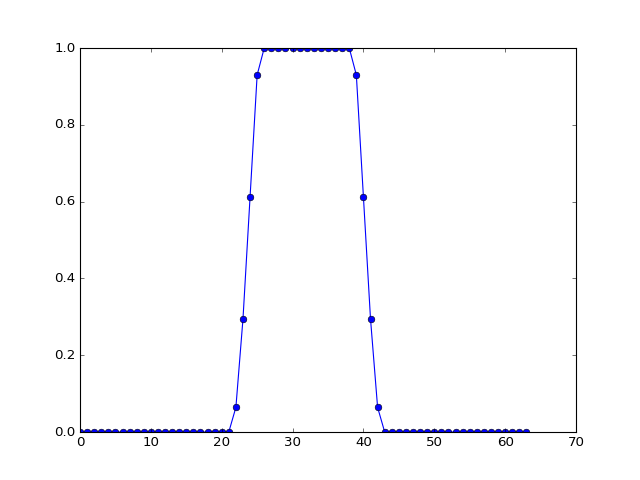

In [15]:
plt.plot(phi[32,32,:],'-o')